In [30]:
from transformer import KroneckerModel
import sys  
sys.path.insert(0, '../symchar')
from symchar import Partition, character_table
from math import factorial

In [31]:
def join_partition(mu, nu):
    return Partition(sorted(mu + nu, reverse=True))

def get_lr_coefficient(i_table, j_table, k_table, lambda_partition, mu_partition, nu_partition):
    i_character = i_table.get_character(lambda_partition)
    j_character = j_table.get_character(mu_partition)
    k_character = k_table.get_character(nu_partition)
    cumulative_dot_product = 0
    for j_class, j_class_index in j_table.partition_lookup.items():
        for k_class, k_class_index in k_table.partition_lookup.items():
            i_class = join_partition(j_class, k_class)
            i_class_index = i_table.partition_lookup[i_class]
            cumulative_dot_product += j_table.conjugacy_class_sizes[j_class_index]*k_table.conjugacy_class_sizes[k_class_index]*i_character[i_class_index]*j_character[j_class_index]*k_character[k_class_index]
    return cumulative_dot_product // (factorial(j_table.group_number)*factorial(k_table.group_number))

def write_data_for_character_table_i(i, character_table_dict, f):
    i_table = character_table_dict[i]
    for lambda_partition in i_table.partition_lookup:
        for j in range(1, i):
            j_table = character_table_dict[j]
            k = i - j
            k_table = character_table_dict[k]
            for mu_partition in j_table.partition_lookup:
                for nu_partition in k_table.partition_lookup:
                    lr_coefficient = get_lr_coefficient(i_table, j_table, k_table, lambda_partition, mu_partition, nu_partition)
                    if lr_coefficient > 0: 
                        f.write(' '.join([str(part) for part in lambda_partition]) + '  ' + ' '.join([str(part) for part in mu_partition]) + '  ' + ' '.join([str(part) for part in nu_partition]) + '  1\n')
                    else:
                        f.write(' '.join([str(part) for part in lambda_partition]) + '  ' + ' '.join([str(part) for part in mu_partition]) + '  ' + ' '.join([str(part) for part in nu_partition]) + '  0\n')

In [44]:
validation_groups = [i for i in range(3, 16, 2)]
training_groups = [1] + [i for i in range(2, 16, 2)]

In [45]:
character_table_dict = {}
print("Getting character tables")
for i in training_groups + validation_groups:
    print(i)
    character_table_dict[i] = character_table(i)

print("Preparing training data")
with open('lr_training_data.txt', 'w') as f:
    for i in training_groups:
        print(i)
        write_data_for_character_table_i(i, character_table_dict, f)
        
print("Preparing validation data")
with open('lr_validation_data.txt', 'w') as f:
    for i in validation_groups:
        print(i)
        write_data_for_character_table_i(i, character_table_dict, f)

Getting character tables
1
2
4
6
8
10
12
14
3
5
7
9
11
13
15
Preparing training data
1
2
4
6
8
10
12
14
Preparing validation data
3
5
7
9
11
13
15


In [36]:
MAX_PARTITION_LENGTH = 10
MAX_INPUT_LENGTH = 3*MAX_PARTITION_LENGTH
MAX_PART_VALUE = 12

def line_to_data(line):
    partition_1, partition_2, partition_3, ground_truth = line.split('  ')
    partition_1, partition_2, partition_3 = [[int(item)-1 for item in partition.split(' ')] for partition in [partition_1, partition_2, partition_3]]
    lengths = [len(partition) for partition in [partition_1, partition_2, partition_3]]
    if any(length > 10 for length in lengths) or any(value >= MAX_PART_VALUE for value in [partition_1[0], partition_2[0], partition_3[0]]):
        return [None]*5
    total_lengths = sum(lengths)
    mask = [1]*total_lengths + [0]*(MAX_INPUT_LENGTH - total_lengths)
    sequence_positions = lengths[0]*[1] + lengths[1]*[2] + lengths[2]*[3] + [0]*(MAX_INPUT_LENGTH - total_lengths)
    term_positions = [i for i in range(0, lengths[0])] + [i for i in range(0, lengths[1])] + [i for i in range(0, lengths[2])] + [0]*(MAX_INPUT_LENGTH - total_lengths)
    partition_data = partition_1 + partition_2 + partition_3 + [0]*(MAX_INPUT_LENGTH - total_lengths)
    ground_truth = int(ground_truth[0])
    return partition_data, sequence_positions, term_positions, ground_truth, mask

In [46]:
import numpy as np
with open('lr_training_data.txt', 'r') as f:
    lines = f.readlines()
all_partition_data, all_sequence_positions, all_term_positions, all_ground_truths, all_masks = [], [], [], [], []
for line in lines:
    partition_data, sequence_positions, term_positions, ground_truth, mask = line_to_data(line)
    if partition_data is not None:
        all_partition_data.append(partition_data)
        all_sequence_positions.append(sequence_positions)
        all_term_positions.append(term_positions)
        all_ground_truths.append(ground_truth)
        all_masks.append(mask)
        
import torch
x_partition_data = torch.tensor(all_partition_data)
x_sequence_positions = torch.tensor(all_sequence_positions)
x_term_positions = torch.tensor(all_term_positions)
x_masks = torch.tensor(all_masks, dtype=float)
y_data = torch.tensor(all_ground_truths)
TRAIN_SIZE = len(y_data)
train_shuffle = np.random.choice(TRAIN_SIZE, size=TRAIN_SIZE, replace=False)
x_partition_train, x_sequence_train, x_term_train, x_masks_train, y_train = x_partition_data[train_shuffle], x_sequence_positions[train_shuffle], x_term_positions[train_shuffle], x_masks[train_shuffle], y_data[train_shuffle]

In [47]:
VAL_SIZE = 0
with open('lr_validation_data.txt', 'r') as f:
    lines = f.readlines()
validation_dict = {i:{} for i in validation_groups}
current_partition = '3'
current_group = 3
current_dictionary = validation_dict[3]
all_partition_data, all_sequence_positions, all_term_positions, all_ground_truths, all_masks = [], [], [], [], []
for line in lines:
    line_first_partition = line.split('  ')[0]
    if line_first_partition != current_partition:
        x_partition_data = torch.tensor(all_partition_data)
        x_sequence_positions = torch.tensor(all_sequence_positions)
        x_term_positions = torch.tensor(all_term_positions)
        x_masks = torch.tensor(all_masks, dtype=float)
        y_data = torch.tensor(all_ground_truths)
        current_dictionary[current_partition] = (x_partition_data, x_sequence_positions, x_term_positions, x_masks, y_data)
        line_first_digit = int(line_first_partition.split(' ')[0])
        if line_first_digit > current_group:
            current_group = line_first_digit
            current_dictionary = validation_dict[current_group]
        current_partition = line_first_partition
        all_partition_data, all_sequence_positions, all_term_positions, all_ground_truths, all_masks = [], [], [], [], []
    partition_data, sequence_positions, term_positions, ground_truth, mask = line_to_data(line)
    if partition_data is not None:
        all_partition_data.append(partition_data)
        all_sequence_positions.append(sequence_positions)
        all_term_positions.append(term_positions)
        all_ground_truths.append(ground_truth)
        all_masks.append(mask)
        VAL_SIZE += 1
x_partition_data = torch.tensor(all_partition_data)
x_sequence_positions = torch.tensor(all_sequence_positions)
x_term_positions = torch.tensor(all_term_positions)
x_masks = torch.tensor(all_masks, dtype=float)
y_data = torch.tensor(all_ground_truths)
current_dictionary[current_partition] = (x_partition_data, x_sequence_positions, x_term_positions, x_masks, y_data)


In [48]:
model = KroneckerModel(num_tokens=MAX_PART_VALUE, input_embedding_dim=200, vector_dim=200, num_heads=10, num_layers=4, hidden_multiplier=1, dropout_prob=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

model.train()
print('')

In [49]:
from torch import nn
batch_size = 32
num_epochs = 20
stats = []
val_stats = []
solved_partitions = []
for i in range(0, num_epochs):
    print(i)
    total_acc = 0
    temp_acc = 0
    for run, j in enumerate(range(0, TRAIN_SIZE, batch_size)):
        optimizer.zero_grad()
        out = model(x_partition_train[j:j + batch_size], x_sequence_train[j:j + batch_size], x_term_train[j:j + batch_size], x_masks_train[j:j + batch_size])
        sigmoid = nn.Sigmoid()
        loss_function = nn.BCELoss()
        out = sigmoid(out.mean(axis=1).squeeze(1))
        loss = loss_function(out.to(torch.float32), y_train[j:j + batch_size].to(torch.float32))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        batch_acc = sum(torch.logical_and(out > 0.5, y_train[j:j + batch_size] == 1)) + sum(torch.logical_and(out< 0.5, y_train[j:j + batch_size] == 0))
        total_acc += batch_acc
        temp_acc += batch_acc
    print("Train accuracy:", total_acc/TRAIN_SIZE)
    stats.append(total_acc/TRAIN_SIZE)
    model.eval()
    val_acc = 0.0
    for group, group_dictionary in validation_dict.items():
        group_acc = 0
        group_items = 0
        for partition, values in group_dictionary.items():
            if values[0].shape[0] > 0:
                num_items = values[0].shape[0]
                partition_acc = 0
                for j in range(0, num_items, batch_size):
                    out = model(values[0][j:j+batch_size], values[1][j:j+batch_size], values[2][j:j+batch_size], values[3][j:j+batch_size])
                    out = sigmoid(out.mean(axis=1).squeeze(1))
                    partition_acc += sum(torch.logical_and(out > 0.5, values[4][j:j+batch_size] == 1)) + sum(torch.logical_and(out< 0.5, values[4][j:j+batch_size] == 0))
                if partition_acc == num_items and partition not in solved_partitions:
                    print(partition)
                    solved_partitions.append(partition)
                group_items += num_items
                group_acc += partition_acc
        print(group, group_acc/group_items)
        val_acc += group_acc
    print("Validation accuracy:", val_acc/VAL_SIZE)
    val_stats.append(val_acc/VAL_SIZE)
    torch.save(model.state_dict(), f"{i}_lr_writeup_long_run.blob")
    model.train()
    scheduler.step()

0
Train accuracy: tensor(0.9157)
2 1
1 1 1
3 tensor(0.8333)
2 1 1 1
1 1 1 1 1
5 tensor(0.9351)
6 1
4 1 1 1
2 1 1 1 1 1
1 1 1 1 1 1 1
7 tensor(0.9483)
9
8 1
2 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1
9 tensor(0.9656)
11
8 1 1 1
7 1 1 1 1
2 1 1 1 1 1 1 1 1 1
11 tensor(0.9651)
10 1 1 1
13 tensor(0.9631)
15 tensor(0.9593)
Validation accuracy: tensor(0.9603)
1
Train accuracy: tensor(0.9629)
3 tensor(0.8333)
3 2
3 1 1
5 tensor(0.9481)
7
3 2 1 1
3 1 1 1 1
7 tensor(0.9775)
7 2
3 2 1 1 1 1
9 tensor(0.9810)
11 tensor(0.9805)
13 tensor(0.9761)
15 tensor(0.9689)
Validation accuracy: tensor(0.9710)
2
Train accuracy: tensor(0.9787)
3
3 tensor(1.)
2 2 1
5 tensor(0.9740)
5 2
5 1 1
4 2 1
3 2 2
2 2 2 1
2 2 1 1 1
7 tensor(0.9933)
6 3
6 2 1
6 1 1 1
5 2 2
5 2 1 1
5 1 1 1 1
4 1 1 1 1 1
3 2 2 2
3 2 2 1 1
3 1 1 1 1 1 1
2 2 2 1 1 1
2 2 1 1 1 1 1
9 tensor(0.9960)
10 1
9 2
8 2 1
7 2 1 1
6 3 1 1
6 1 1 1 1 1
5 1 1 1 1 1 1
4 3 2 1 1
3 2 2 2 1 1
3 2 2 1 1 1 1
3 1 1 1 1 1 1 1 1
2 2 2 2 1 1 1
2 2 2 1 1 1 1 1
11 tensor(0.9946)


tensor(0.8804)

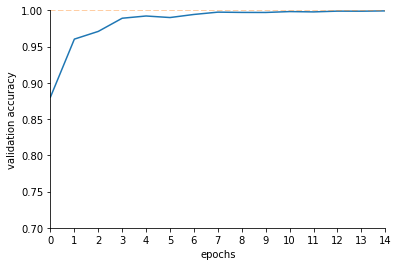

In [62]:
from matplotlib import pyplot as plt
val_data_lr = [1-torch.sum(y_train)/y_train.shape[0]] + val_stats
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.plot([i for i in range(0, 15)], val_data_lr[:15], label='littlewood-richardson')
plt.plot([i for i in range(0, 15)], [1 for i in range(0, 15)], '--', alpha=0.5)
plt.xticks([i for i in range(0, 15)])
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.ylim(0.7, 1.0)
plt.xlim(0, 14)
plt.show()

In [63]:
y_train.shape

torch.Size([394722])

In [65]:
[1-torch.sum(y_train)/y_train.shape[0]] + val_stats

[tensor(0.8804),
 tensor(0.9603),
 tensor(0.9710),
 tensor(0.9891),
 tensor(0.9922),
 tensor(0.9901),
 tensor(0.9944),
 tensor(0.9975),
 tensor(0.9972),
 tensor(0.9971),
 tensor(0.9983),
 tensor(0.9979),
 tensor(0.9989),
 tensor(0.9988),
 tensor(0.9993),
 tensor(0.9989),
 tensor(0.9995),
 tensor(0.9994),
 tensor(0.9992),
 tensor(0.9997),
 tensor(0.9997)]